## 서울사고건수 LSTM 예시

In [219]:
#데이터 핸들링에 사용되는 라이브러리
import pandas as pd
import numpy as np

#데이터 시각화 라이브러리
import seaborn as sns
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.family':'AppleGothic'})
mpl.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

#머신러닝 라이브러리
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

#CPU만 작동하게 하는 명령어(for Mac)
tf.config.list_physical_devices()
tf.config.experimental.set_visible_devices([], 'GPU')

#머신러닝 평가에 사용되는 보조
from sklearn import model_selection
from keras import models,layers
from keraspp import skeras

In [220]:
#파일 불러오기
#2017~2019년도
df = pd.read_csv('./LSTM_데이터/서울사고건수(2017~2019).csv')
#아래 데이터와 2017년도가 겹치므로 18~19년도만 선택하면
df= df.iloc[365:]

#2015~2017년도
#18~19년도 데이터 형식에 맞게 전처리
df2= pd.read_excel('./LSTM_데이터/서울발생건수(2015~2017).xlsx')
df2.drop(['Unnamed: 0','발생시도'],axis=1,inplace=True)
df2.rename({'계':'사고건수'},axis=1,inplace=True)

#날짜를 datatime으로 변환하기 위해선 20XX-XX-XX 00:00:00'형식으로 맞출 필요가 있는걸로 보임
#따라서 그에 적절하게 형태를 바꿈
year_lst=[]
month_lst=[]
day_lst=[]
str_date_lst=[]

for i in range(len(df2['발생일'])):
    year_lst.append(str(df2['발생일'][i])[:4])
    month_lst.append(str(df2['발생일'][i])[4:6])
    day_lst.append(str(df2['발생일'][i])[6:])
    str_date_lst.append(year_lst[i]+'-'+month_lst[i]+'-'+day_lst[i]+' '+'00:00:00')
df2['발생일']=str_date_lst


#데이터 프레임 합치기
df= pd.concat([df2,df])
#데이터 타입변환 str->datetime으로
df['발생일']=pd.to_datetime(df['발생일'])
print(df.info())
#날짜순으로 정렬
df.sort_values(by='발생일')
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   발생일     1826 non-null   datetime64[ns]
 1   사고건수    1826 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.8 KB
None


,발생일,사고건수
0,2015-01-01,62
1,2015-01-02,64
2,2015-01-03,94
3,2015-01-04,86
4,2015-01-05,123
...,...,...
1821,2019-12-27,94
1822,2019-12-28,94
1823,2019-12-29,78
1824,2019-12-30,91


## 분포 확인

In [221]:
#교육 및 예측을 수행하기 전에 데이터가 어떻게 표시되는지 plotly 사용하여 시각화
print("Plotly Version: ",plotly.__version__)

trace = go.Scatter(
    x = df['발생일'],
    y = df['사고건수'],
    mode = 'lines',
    name = 'Data'
)
layout = go.Layout(
    title = "",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Accident"}
)
fig = go.Figure(data=[trace], layout=layout)
fig.show()


Plotly Version:  5.9.0


## 정규화 처리

In [222]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
df_target = df['사고건수']
df_scaled = scaler.fit_transform((df_target.values).reshape(-1,1))

#데이터프레임으로 볼때 사용. 텐서플로 연산의 input으로 사용할 땐  row vector 형태여서 다시 데이터타입을 바꾼다
df_scaled = pd.DataFrame(df_scaled,columns=['사고건수'])
df_scaled

,사고건수
0,0.154839
1,0.167742
2,0.361290
3,0.309677
4,0.548387
...,...
1821,0.361290
1822,0.361290
1823,0.258065
1824,0.341935


## 데이터 사전처리
- 분석을 위해 처음 80%의 데이터에 대해 모델을 교육하고 나머지 20%에 대해 테스트

In [223]:
accident_data= df_scaled.values
accident_data= accident_data.reshape(-1,1)
accident_data


split_percent = 0.80
split = int(split_percent*len(accident_data))

accident_train = accident_data[:split]
accident_test = accident_data[split:]

date_train = df['발생일'][:split]
date_test = df['발생일'][split:]


print(len(accident_train))
print(len(accident_test))
print((accident_train))
print((accident_test))

1460
366
[[0.15483871]
 [0.16774194]
 [0.36129032]
 ...
 [0.48387097]
 [0.30967742]
 [0.2       ]]
[[0.44516129]
 [0.15483871]
 [0.37419355]
 [0.41290323]
 [0.4       ]
 [0.36774194]
 [0.09032258]
 [0.32258065]
 [0.47096774]
 [0.39354839]
 [0.4       ]
 [0.47741935]
 [0.36129032]
 [0.21290323]
 [0.40645161]
 [0.36774194]
 [0.37419355]
 [0.41935484]
 [0.41935484]
 [0.32258065]
 [0.3483871 ]
 [0.3483871 ]
 [0.42580645]
 [0.38709677]
 [0.4516129 ]
 [0.58064516]
 [0.39354839]
 [0.17419355]
 [0.48387097]
 [0.41935484]
 [0.48387097]
 [0.4       ]
 [0.47096774]
 [0.2       ]
 [0.20645161]
 [0.05806452]
 [0.        ]
 [0.06451613]
 [0.33548387]
 [0.32258065]
 [0.19354839]
 [0.16129032]
 [0.28387097]
 [0.36129032]
 [0.41935484]
 [0.52258065]
 [0.5483871 ]
 [0.41290323]
 [0.47096774]
 [0.38709677]
 [0.26451613]
 [0.32258065]
 [0.4516129 ]
 [0.49032258]
 [0.49032258]
 [0.23225806]
 [0.42580645]
 [0.37419355]
 [0.25806452]
 [0.41935484]
 [0.27741935]
 [0.27096774]
 [0.18064516]
 [0.2516129 ]
 [0.2

- 교육을 실시하기 전에 데이터를 크게 수정해야 함
- 우리의 데이터는 여전히 시퀀스고 neural network은 supervised model로 훈련되기 때문에 데이터를 시퀀스에서 supervised data로 변환해야 함
- 기계 학습 모델의 신경망을 훈련하려면 데이터가 {<features>,<target>} 형식이어야 함
- 마찬가지로 주어진 데이터를 이 형식으로 변환해야 함 => 룩백

## Keras의 시계열 생성기 tf.keras.TimeseriesGenerator
- 시간 순서가 있는 데이터의 배치를 생성하는 도구 클래스
- arguments로 (data,targets,lengths,sample_rate=1,stride=1,start_index=0,end_index,shuffle=False,reverse=False,
batch_size=128)를 갖는다
- arguements에 대한 설명
    - data: 리스트 또는 NumPy 배열과 같이 인덱싱 가능한 2D 데이터로 0번째 축axis은 연속된 시점에 모인 표본sample들로 이루어진 시간 차원을 나타냅니다.
    - targets: data의 시간 단계와 상응하는 목표값으로 0번째 축의 길이가 data와 서로 같아야 합니다.
    - length: 생성할 배치의 시계열 길이를 지정합니다. 해당 인자를 통해 지정되는 길이는 최대 길이로서, 각 표본의 실제 길이는 length를 sampling_rate로 나눈 몫만큼이 됩니다.
    - sampling_rate: length를 통해 지정된 시계열 범위 가운데 sampling_rate 시점마다 입력값을 추출해서 배치에 포함시킬 것인지를 정합니다. 예를 들어 표본이 i번째 데이터에서
    시작할 때 sampling_rate를 r로 설정할 경우 생성되는 표본은 data[i], data[i+r], data[i+2r]... 의 형태가 되며, 표본의 최종 길이는 length를 sampling_rate로 나눈 몫이 됩니다. 기본값은 1이며, 이 경우 배치의 길이는 length와 같아집니다.
    - stride: 입력값 가운데 stride로 지정한 순서마다 표본을 생성합니다. 예를 들어 첫번째 시계열 표본이 i번째 입력값에서 시작할 때 stride가 s면 다음 표본은 data[i+s]부터, 그
    다음 표본은 data[i+2s]부터 생성됩니다. 표본 사이에 데이터가 중복되지 않게 하려면 stride값을 length보다 같거나 크게 지정하면 됩니다. 기본값은 1입니다.
    - start_index: 입력값 가운데 배치 생성에 사용할 최초 시점을 지정합니다. start_index이전의 데이터는 사용되지 않기 때문에 별도의 시험/검증 세트를 만드는 데 활용할 수 있습니다.
    기본값은 0입니다.
    - end_index: 입력값 가운데 배치 생성에 사용할 마지막 시점을 지정합니다. end_index이후의 데이터는 사용되지 않기 때문에 별도의 시험/검증 세트를 만드는 데 활용할 수 있습니다. 기본값은
    None으로, 이 경우 입력 데이터의 가장 마지막 인덱스가 자동으로 지정됩니다.
    - shuffle: bool. True인 경우, 생성한 표본의 순서를 뒤섞습니다. 기본값은 False입니다.
    - reverse: bool. True인 경우, 생성한 표본의 순서는 입력된 데이터의 역순입니다. 기본값은 False입니다.
    - batch_size: 하나의 배치 안에 포함될 표본의 개수입니다. 기본값은 128입니다.

### 생성모델: 주어진 학습 데이터를 학습하여 학습 데이터의 분포를 따르는 유사한 데이터를 생성하는 모델

In [224]:
#Keras의 시계열 생성기(TimeseriesGenerator) 모듈 사용
# 15일을 간격으로 설정하였음
look_back = 15
train_generator = TimeseriesGenerator(accident_train, accident_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(accident_test, accident_test, length=look_back, batch_size=1)

## Keras tf.keras.layers.LSTM
Arguments

- units: Positive integer, dimensionality of the output space.
- activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is
applied (ie. "linear" activation: a(x) = x).
- recurrent_activation: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass
None, no activation is applied (ie. "linear" activation: a(x) = x).
- use_bias: Boolean (default True), whether the layer uses a bias vector.
- kernel_initializer: Initializer for the kernel weights matrix, used for the linear transformation of the inputs.
Default: glorot_uniform.
- recurrent_initializer: Initializer for the recurrent_kernel weights matrix, used for the linear transformation of
the recurrent state. Default: orthogonal.
- bias_initializer: Initializer for the bias vector. Default: zeros.
- unit_forget_bias: Boolean (default True). If True, add 1 to the bias of the forget gate at initialization. Setting
it to true will also force bias_initializer="zeros". This is recommended in Jozefowicz et al..
- kernel_regularizer: Regularizer function applied to the kernel weights matrix. Default: None.
- recurrent_regularizer: Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
bias_regularizer: Regularizer function applied to the bias vector. Default: None.
- activity_regularizer: Regularizer function applied to the output of the layer (its "activation"). Default: None.
- kernel_constraint: Constraint function applied to the kernel weights matrix. Default: None.
- recurrent_constraint: Constraint function applied to the recurrent_kernel weights matrix. Default: None.
- bias_constraint: Constraint function applied to the bias vector. Default: None.
- dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
- recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the
recurrent state. Default: 0.
- return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default:
 False.
- return_state: Boolean. Whether to return the last state in addition to the output. Default: False.
- go_backwards: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
- stateful: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as
initial state for the sample of index i in the following batch.
- time_major: The shape format of the inputs and outputs tensors. If True, the inputs and outputs will be in shape
[timesteps, batch, feature], whereas in the False case, it will be [batch, timesteps, feature]. Using time_major = True is a bit more efficient because it avoids transposes at the beginning and end of the RNN calculation. However, most TensorFlow data is batch-major, so by default this function accepts input and emits output in batch-major form.
unroll: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [225]:
#Neural Network, 데이터가 준비 되었으니 네트워크를 만들고 교육할 수 있음
#loss='mse'를 많이 사용

from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(None, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [226]:
#학습시간이 궁금하여 time 함수를 추가하였음
from time import time
t_0= time()

num_epochs = 500
hist= model.fit(train_generator, epochs=num_epochs, verbose=True)
print(f'학습에 걸린 시간은 {str(time()-t_0)} 입니다')

Epoch 1/500
73/73 [==============================] - 1s 5ms/step - loss: 0.0286
Epoch 2/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0175
Epoch 3/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 4/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 5/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 6/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 7/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 8/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 9/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 10/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 11/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 12/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 13/500
73/73 [=================

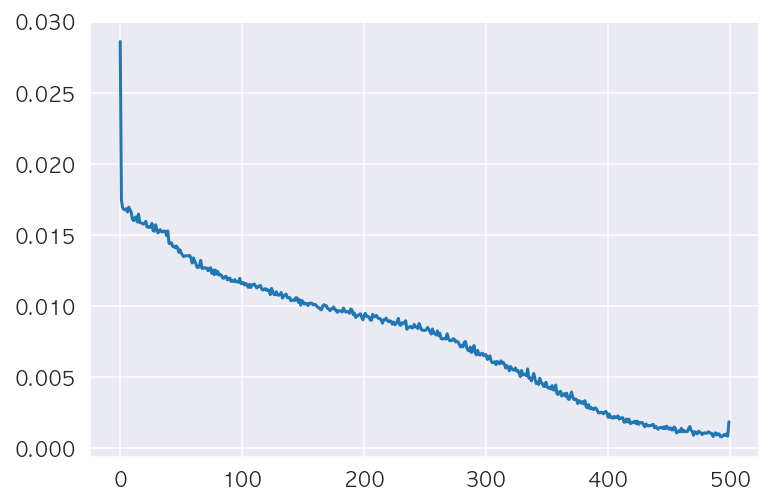

In [227]:
plt.plot(hist.history['loss'])


In [228]:
#예측(Prediction, 검정 데이터에 대해 모형을 검정하고 예측과 실제 값이 겹치는지 확인할 수 있음)
#Ground Truth : 우리가 정한 정답, 우리의 모델이 우리가 원하는 답으로 예측해주길 바라는 답

prediction = model.predict_generator(test_generator)

#정규화한 값을 다시 원래의 값으로 inverse transform하기
accident_train= scaler.inverse_transform(accident_train.reshape(-1,1))
accident_test= scaler.inverse_transform(accident_test.reshape(-1,1))
prediction= (scaler.inverse_transform(prediction.reshape((1,-1))))

accident_train = accident_train.reshape((-1))
accident_test = accident_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = accident_train,
    mode = 'lines',
    name = 'Data'

)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction',
    opacity = 0.5,

)
trace3 = go.Scatter(
    x = date_test,
    y = accident_test,
    mode='lines',
    name = 'Ground Truth',
    opacity = 0.5,

)
layout = go.Layout(
    title = "-",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Accident"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()


/var/folders/m9/0vsmjxhd7q30k5mzw0bk58hh0000gn/T/ipykernel_4743/1351118244.py:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



12/12 [==============================] - 0s 1ms/step


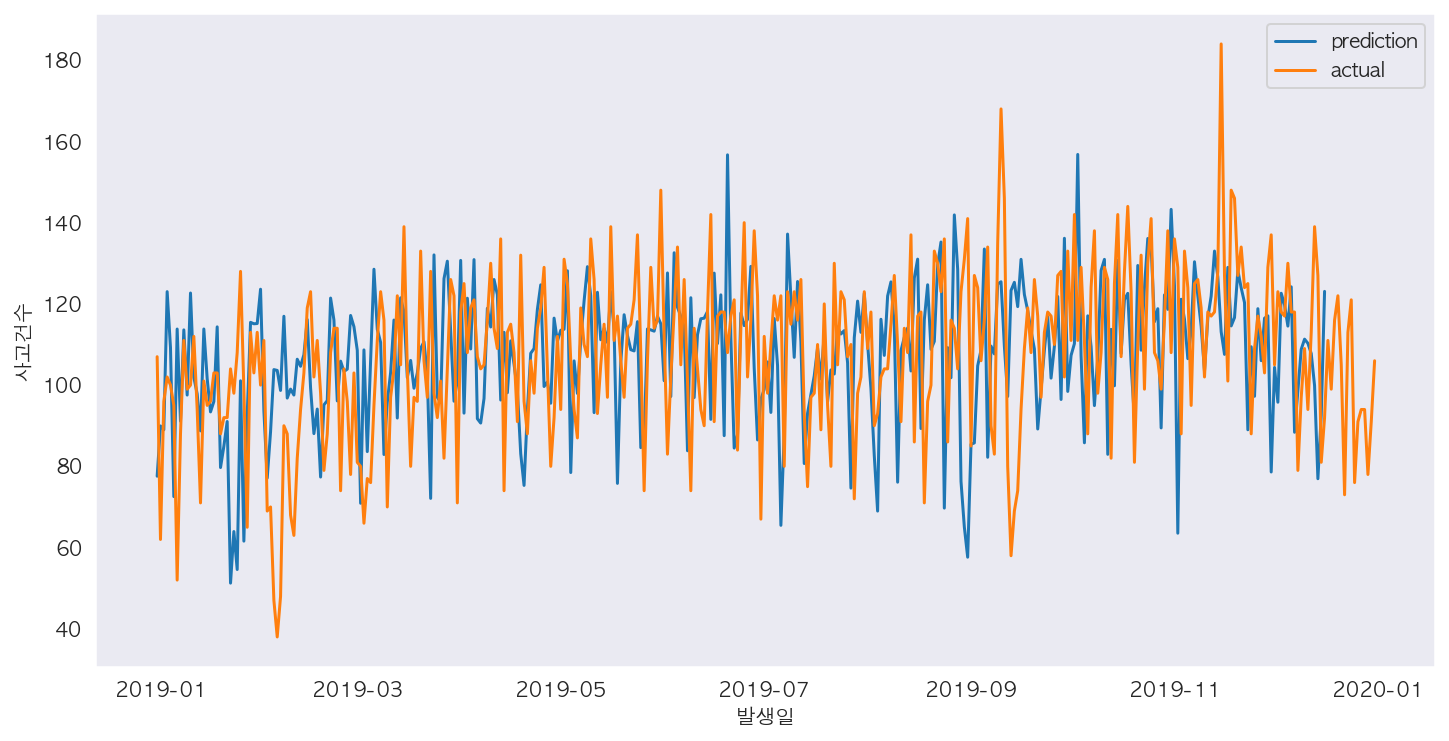

In [229]:
pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.xlabel('발생일')
plt.ylabel('사고건수')
plt.plot(date_test[:351],prediction, label='prediction')
plt.plot(date_test,accident_test, label='actual')
plt.grid()
plt.legend(loc='best')

plt.show()